In [60]:
import pandas_datareader as pdr
import requests
import pandas as pd
from datetime import datetime, timedelta
import sqlite3 
import sql_tools
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pylab as plt
import seaborn as sea
from scipy import stats
pick = sql_tools.IcePick(sqlite3, 'trade_history.sqlite')
con = sqlite3.connect('trade_history.sqlite')
phi = (1 + np.sqrt(5))/2

In [2]:
def download_data(ticker, data_source = 'yahoo',  *args, **kwargs):
    i = 0
    while True:
        try:
            print('Trying to Download: {}'.format(ticker))
            data = pdr.DataReader(ticker, data_source, *args, **kwargs)
            return data
        except pdr.base.RemoteDataError as e:
            i = i + 1
            print(e)
            print('Error {} : Exponential Backoff time: {}'.format(i , i**2))
            
            if i > 7:
                print('Error Got too big, raising it')
                raise e 
            time.sleep(i ** 2)
            
bar_pos = 0            
def progress_bar(i, left):
    
    global bar_pos
    bar_pos = bar_pos + 1
    power_of_one_dot = 100/left
    pos = int(power_of_one_dot * i)
    bar = ''

    for num in range(0, pos -1 ):
        if (num + bar_pos) %2 == 0:
            bar = bar + '-'
        if (num + bar_pos) %2 != 0:
            bar = bar + '🚃'             
    bar = bar + '🚢'
    for num in range(0, 100 - pos):
        bar = bar + ' '
    bar = '-' + bar
    bar = bar + '| {:.2f} % \nDone: {} Remaining: {}'.format(100 * i/(left -1), i, left - i )
    print(bar)



In [3]:
def download_tickers():
    nyse = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&render=download')
    nasdaq = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download')
    data = nyse.append(nasdaq)
    data['Symbol']= data['Symbol'].str.replace(' ', '')
    data = data.set_index('Symbol')
    data = data[~data.index.duplicated()]
    data = data[~data.index.str.contains('\^')]
    data = data[~data.index.str.contains('\.')]
    data = data[~data.index.str.contains('\~')]
    data = data[data['MarketCap'] > 0]
    del data['Unnamed: 9']
    data['table_name'] = '_'+ data.index + '_'
    return data
tickers = download_tickers()

def create_updates(tickers):
    updates = pd.DataFrame(index = set(tickers))
    updates['last_updated'] = datetime(2018,1,24)
    updates.index.name = 'ticker'
    updates.to_sql('tickers', con, if_exists='replace')
    

def save_timestamp(ticker, time):
    with pick.get_connection() as cur:
        sql = "CREATE TABLE IF NOT EXISTS tickers (id text primary key, ticker text, last_updated text);"
        cur.execute(sql)
        
    with pick.get_connection() as cur:
        sql = """
        INSERT OR REPLACE INTO tickers(id, ticker, last_updated)
        Values ('{}', '{}', '{}')
        """.format( '_' + ticker + '_', ticker, time)
        cur.execute(sql)
    return

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
def save_data(data, ticker = None, kind = ''):
    ''' kind must be one of:update, reset '''
    ok_types = ['update', 'reset']
    if kind not in ok_types:
        raise ValueError( ' argument kind must be one of the following: {}'.format(','.join(ok_types)))
    if (type(data) == pd.DataFrame) and (type(ticker) == type(None)):
        raise ValueError( 'Must Specify ticker argument with type = \'Dataframe\'')
    if type(data) == pd.core.panel.Panel:
        for ticker in data.minor_axis:
            candles = data.minor_xs(ticker)
            save_data(candles, ticker, kind)
            
    if type(data) == pd.DataFrame:
        _ticker_ = '_' + ticker + '_'
        data.columns = data.columns.str.replace(' ', '_')
        data = data.fillna("'nan'").replace('nan', "'nan'")
        if kind == 'reset':
            with pick.get_connection() as con:
                sql = "DROP TABLE IF EXISTS {} ".format(_ticker_)
                con.execute(sql)
            with pick.get_connection() as con:    
                sql = """ create table {} (Date text primary key,
                Open real ,High real ,Low real ,
                Close real ,Adj_Close real, Volume real )""".format(_ticker_)
                con.execute(sql)
            kind = 'update'
            
        if kind == 'update':
            
            column_names = list([data.index.name]) + list(data.columns)
            sql = """ INSERT OR REPLACE INTO {}({})\nValues """.format(_ticker_,','.join(column_names) )
            value_bit = []
            for date in data.index:
                row = data.loc[date]
                others = ','.join(row.apply(str).values)
                value_bit.append( " ('{}', {} )".format(date, others))
            sql = sql + ',\n'.join(value_bit)
            with pick.get_connection() as con:
                con.execute(sql)
                con.commit()


        latest_date = data.index.max()
        save_timestamp(ticker, latest_date)
    return 
        

In [4]:
def update_tickers(to_date):
    t = pd.to_datetime
    to_date = t(t(to_date).strftime('%Y-%m-%d'))
    tables = pick.get_data('tickers')
    tables = tables.set_index('table_name')
    tables['last_updated'] = pd.to_datetime(tables['last_updated'])

    tables['need_update'] = tables['last_updated'] < to_date
    tables=  tables[tables['need_update']]
    
    i = 0
    batch_size = 10
    to_do_length = len(tables)
    for thing in batch(tables, batch_size):
        downloaded_data = download_data(thing.index)
        downloaded_data = pd.DataFrame()
        save_data(downloaded_data, kind = 'update')
        
        i = min(i + batch_size, to_do_length)
        progress_bar(i,to_do_length)
        clear_output(True)
        
    return tables
#x = update_tickers(datetime.today())

In [80]:
def load_ticker(ticker):
    if '_' not in ticker:
        ticker = '_{}_'.format(ticker)
    data = pick.get_data(ticker).set_index('Date')
    for column in data.columns:
        try:
            mask = data[column].apply(str).str.contains('nan')
            data.loc[mask, column] = np.nan
        except TypeError:
            pass
    data.index = pd.to_datetime(data.index)
    return data



In [105]:
ticker = 'AMD'

try:
    ticker = load_ticker(ticker)
except:
    data = download_data(ticker, start = datetime(2001, 1, 1))
    save_data(data, ticker, 'reset')
    data = load_ticker(ticker)

In [115]:
data['day_change'] = data['Close']/data['Open']
data['night_change'] = data['Open']/data['Close'].shift(1) 
data['night_change'] = data['night_change'].shift(-1) 
data['twenty_four_hour_change'] = 1 + data['Close'].pct_change()
data = data.dropna()

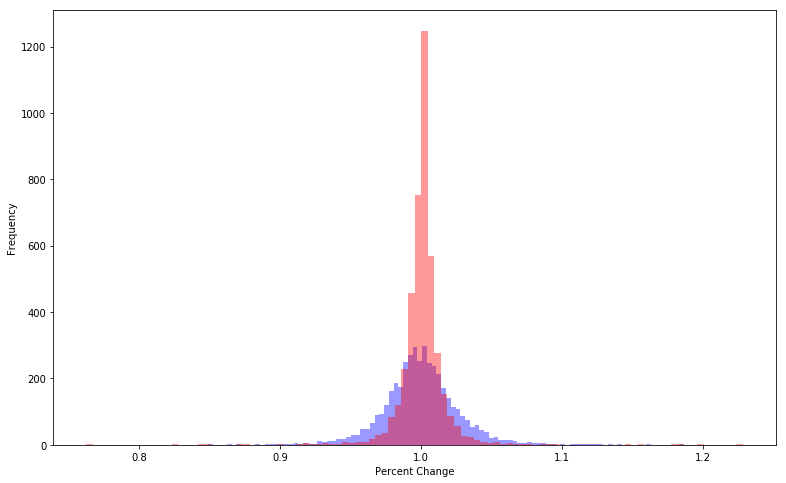

Ttest_indResult(statistic=-1.9870037194601171, pvalue=0.046953792438452865)
        day_change  night_change
count  4283.000000   4283.000000
mean      0.999643      1.000589
std       0.026548      0.016317
min       0.848551      0.762295
25%       0.985249      0.995511
50%       0.998945      1.000000
75%       1.013651      1.005654
max       1.186480      1.228188


In [119]:
fig, ax = plt.subplots()
fig.set_size_inches(8 * phi,8 )
sea.distplot(data['day_change'], color = 'blue', bins = 100, kde = False)
sea.distplot(data['night_change'], color = 'red', bins = 100, kde = False)
#sea.distplot(data['twenty_four_hour_change'], color = 'yellow', bins = 100, kde = False)
ax.set_xlabel('Percent Change')
ax.set_ylabel('Frequency')
plt.show()

print(stats.ttest_ind(data['day_change'], data['night_change']))
print(data[['day_change', 'night_change']].describe())

In [95]:
data['month'] = data.index.month

In [99]:
for month, group in data.groupby('month'):
    print(data['month'])

Date
2001-01-02     1
2001-01-03     1
2001-01-04     1
2001-01-05     1
2001-01-08     1
2001-01-09     1
2001-01-10     1
2001-01-11     1
2001-01-12     1
2001-01-16     1
2001-01-17     1
2001-01-18     1
2001-01-19     1
2001-01-22     1
2001-01-23     1
2001-01-24     1
2001-01-25     1
2001-01-26     1
2001-01-29     1
2001-01-30     1
2001-01-31     1
2001-02-01     2
2001-02-02     2
2001-02-05     2
2001-02-06     2
2001-02-07     2
2001-02-08     2
2001-02-09     2
2001-02-12     2
2001-02-13     2
              ..
2017-12-18    12
2017-12-19    12
2017-12-20    12
2017-12-21    12
2017-12-22    12
2017-12-26    12
2017-12-27    12
2017-12-28    12
2017-12-29    12
2018-01-02     1
2018-01-03     1
2018-01-04     1
2018-01-05     1
2018-01-08     1
2018-01-09     1
2018-01-10     1
2018-01-11     1
2018-01-12     1
2018-01-16     1
2018-01-17     1
2018-01-18     1
2018-01-19     1
2018-01-22     1
2018-01-23     1
2018-01-24     1
2018-01-25     1
2018-01-26     1
2018-01-2